# Testing LSH reduction on MNIST

In [2]:
from LSH_reduction import * 
from resnet18_model import * 
import math
import time
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
from random import choices
import copy
import os
import subprocess
from torchvision import transforms
import torch.nn as nn
import csv
import copy

cos_sim = lambda a,b: np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [3]:
def accuracy(rp, p, shrinkage = 'LSH'):
    global trainset
    global testset
    global net
    t0 = time.time()
    
    learning_rate = 0.001
    epochs = 7
    batch_size = 256
    
    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    net = ResNet(img_channels = 1, num_layers = 18, block = BasicBlock, num_classes = len(rp.label_to_reps))
    net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
    
    if p == 0:
        trainset_reduced = trainset
    elif shrinkage == 'LSH':
        ixs_shrinked = shrink(rp, p)
        trainset_reduced = torch.utils.data.Subset(trainset, ixs_shrinked)
    else:
        full_data_size = rp.array.shape[0]
        ixs_shrinked = np.random.randint(low = 0, high = full_data_size, size = int(full_data_size*(1-p)))
        trainset_reduced = torch.utils.data.Subset(trainset, ixs_shrinked)
        
    trainloader = torch.utils.data.DataLoader(trainset_reduced, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)
    for epoch in range(1, epochs+1):
        train_loss, train_acc = train(epoch, net, criterion, optimizer, trainloader, device=device)
        test_loss, test_acc = test(epoch, net, criterion, testloader, device=device)

    return (test_acc, time.time()-t0, std_accs(rp, net, testloader))

In [4]:
def std_accs(rp, net, testloader):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in rp.label_to_reps}
    total_pred = {classname: 0 for classname in rp.label_to_reps}

    # no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.cuda())
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[label.item()] += 1
                total_pred[label.item()] += 1

    # Get accuracy by label
    accs = [100 * float(correct_count) / total_pred[classname] for classname, correct_count in sorted(correct_pred.items())]
    accs = np.array(accs)
    return np.nanstd(accs)

In [5]:
# Downloading and getting the E-MNIST letter dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print("trainset len:", len(trainset))

trainset len: 60000


In [7]:
%%time
# Create instance of our rp class
rp = Random_projection_hash(trainset)
rp.hash_values()
rp.estimation()

Using: 8 bits, 3 hash tables
CPU times: user 9.4 s, sys: 1.87 s, total: 11.3 s
Wall time: 7.75 s


In [11]:
n_reps = 5 # number of times each percentage will be tested
max_p = 90

## Save values for later plotting
acc_res_lsh = []
time_res_lsh = []
std_res_lsh = []

acc_res_random = []
time_res_random = []
std_res_random = []

for p in range(int((max_p + 10)/100)):
    total_acc_lsh = 0
    total_time_lsh = 0
    total_std_lsh = 0
    
    total_acc_random = 0
    total_time_random = 0
    total_std_random = 0
    
    for _ in range(n_reps):
        local_res = accuracy(rp, p/10, 'LSH')
        total_acc_lsh += local_res[0]
        total_time_lsh += local_res[1]
        total_std_lsh += local_res[2]
        
        local_res = accuracy(rp, p/10, 'random')
        total_acc_random += local_res[0]
        total_time_random += local_res[1]
        total_std_random += local_res[2]
        
    avg_acc_lsh = total_acc_lsh/n_reps
    avg_time_lsh = total_time_lsh/n_reps
    avg_std_lsh = total_std_lsh/n_reps
    print(f'LSH p: {10*p}%  |  {avg_acc_lsh:.5f}  |  {avg_time_lsh:.5f}  |  {avg_std_lsh:.5f}')
    
    acc_res_lsh.append(avg_acc_lsh)
    time_res_lsh.append(avg_time_lsh)
    std_res_lsh.append(avg_std_lsh)
    
    avg_acc_random = total_acc_random/n_reps
    avg_time_random = total_time_random/n_reps
    avg_std_random = total_std_random/n_reps
    print(f'RND p: {10*p}%  |  {avg_acc_random:.5f}  |  {avg_time_random:.5f}  |  {avg_std_random:.5f}\n')
    
    acc_res_random.append(avg_acc_random)
    time_res_random.append(avg_time_random)
    std_res_random.append(avg_std_random)

LSH p: 0%  |  98.82200  |  23.21081  |  0.53219
RND p: 0%  |  98.78600  |  22.98268  |  0.57108

LSH p: 10%  |  98.87800  |  21.65251  |  0.43311
RND p: 10%  |  98.57000  |  20.94494  |  0.66466

LSH p: 20%  |  98.77000  |  19.85168  |  0.55453
RND p: 20%  |  98.48800  |  19.11128  |  0.73469

LSH p: 30%  |  98.77400  |  18.21992  |  0.60829
RND p: 30%  |  98.44800  |  17.28115  |  0.69968

LSH p: 40%  |  98.70600  |  16.48286  |  0.60775
RND p: 40%  |  98.32800  |  15.31102  |  0.78248

LSH p: 50%  |  98.61800  |  14.73336  |  0.61855
RND p: 50%  |  98.20200  |  13.39153  |  0.75109

LSH p: 60%  |  98.56000  |  12.94163  |  0.60580
RND p: 60%  |  98.09800  |  11.42273  |  0.78103

LSH p: 70%  |  98.48000  |  11.34625  |  0.69578
RND p: 70%  |  97.77400  |  9.52770  |  0.91821

LSH p: 80%  |  98.02800  |  9.67425  |  0.82802
RND p: 80%  |  97.39200  |  7.68304  |  1.03659

LSH p: 90%  |  97.26000  |  8.06625  |  1.27550
RND p: 90%  |  96.41200  |  5.67914  |  1.50471



In [12]:
acc_res_lsh = np.array(acc_res_lsh)
std_res_lsh = np.array(std_res_lsh)

acc_res_random = np.array(acc_res_random)
std_res_random = np.array(std_res_random)

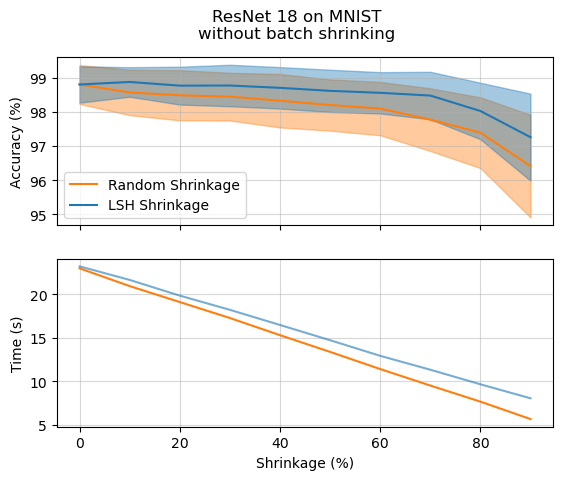

In [16]:
fig, ax = plt.subplots(2,1, sharex = True)
p = [10*i for i in range(int((max_p + 10)/100))]

a = 1/2*(acc_res_random[0] + acc_res_lsh[0])
acc_res_random[0] = a
acc_res_lsh[0] = a

ax[0].grid(alpha = 0.5)
ax[1].grid(alpha = 0.5)

ax[0].plot(p, acc_res_random, c = 'tab:orange', label = 'Random Shrinkage')
ax[0].fill_between(p, acc_res_random - std_res_random, acc_res_random + std_res_random, color = 'tab:orange', alpha = 0.4)
ax[0].plot(p, acc_res_lsh, c = 'tab:blue', label = 'LSH Shrinkage')
ax[0].fill_between(p, acc_res_lsh - std_res_lsh, acc_res_lsh + std_res_lsh, color = 'tab:blue', alpha = 0.4)
ax[0].set_ylabel('Accuracy (%)')

ax[1].plot(p, time_res_random, c = 'tab:orange')
ax[1].plot(p, time_res_lsh, c = 'tab:blue', alpha = 0.6)
ax[1].set_ylabel('Time (s)')

ax[0].legend()
ax[1].set_xlabel('Shrinkage (%)')
fig.suptitle('ResNet 18 on MNIST\nwithout batch shrinking')
plt.savefig('Resnet18_on_MNIST.png')